<a href="https://colab.research.google.com/github/urmzd/school/blob/main/year-four/CSCI4155/assignments/a1/Assignment1-Step2-Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 2

In step 2 you will be using **Pytorch** to import MNIST, train a neural network on MNIST, find examples that "fool" that trained network, and, if you're a 6505 student, propose a way to deal with these examples.

## Question 1

Start by importing both the training and testing MNIST datasets using DataLoaders and the torchvision provided datasets. You can set both the training and testing batch size to be whatever you feel is best.

In [19]:
!pip install loguru

In [20]:
from torch.utils.data import random_split, DataLoader
from loguru import logger
from torch.nn.functional import cross_entropy
import numpy as np
import sys
import torchvision
import random
import torch

SEED_NO = 100
random.seed(SEED_NO)
torch.manual_seed(SEED_NO)
np.random.seed(SEED_NO)

LOGGER_LEVEL = "INFO"
BATCH_SIZE = 64

logger.remove()
logger.add(sys.stderr, level=LOGGER_LEVEL)

3

In [21]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST("/tmp/mnist", download=True, transform=transformer)
total_dataset_size = len(mnist_dataset)
logger.trace(total_dataset_size)

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_set, val_set = random_split(mnist_dataset, lengths=[10000, 50000])

train_dl = DataLoader(train_set, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_set, batch_size=BATCH_SIZE)

logger.debug(f"TRAIN LENGTH: {len(train_set)}; VAL LENGTH: {len(val_set)}")
logger.info(f"CUDA: {torch.cuda.is_available()}")

2022-03-21 01:58:59.901 | INFO     | __main__:<module>:14 - CUDA: True


## Question 2

Define a network with the following architecture:

Conv2d (input channels=1, output channels = 15,kernel size = 5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Conv2d (input channels=15, output channels = 30,kernel size = 5)
$\rightarrow$
Dropout2d (p = 0.5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Linear(input dimension = 480, hidden units = 64)
$\rightarrow$
ReLU
$\rightarrow$
Dropout (p=0.5)
$\rightarrow$
Linear(input dimension = 64, hidden units = 10)
$\rightarrow$
LogSoftMax

In [22]:
class Print(torch.nn.Module):
    def __init__(self):
        super(Print, self).__init__()

    def forward(self, x):
        logger.trace(x.shape)
        return x

conv_net = torch.nn.Sequential(
    Print(),
    torch.nn.Conv2d(in_channels=1, out_channels=15,kernel_size=5),
    Print(),
    torch.nn.MaxPool2d(kernel_size=2),
    Print(),
    torch.nn.ReLU(),
    Print(),
    torch.nn.Conv2d(in_channels=15, out_channels=30, kernel_size=5),
    Print(),
    torch.nn.Dropout2d(p=0.5),
    Print(),
    torch.nn.MaxPool2d(kernel_size=2),
    Print(),
    torch.nn.ReLU(),
    Print(),
    torch.nn.Flatten(start_dim=1),
    Print(),
    torch.nn.Linear(in_features=480,out_features=64),
    Print(),
    torch.nn.ReLU(),
    Print(),
    torch.nn.Dropout(p=0.5),
    Print(),
    torch.nn.Linear(in_features=64, out_features=10),
    Print(),
    torch.nn.LogSoftmax() 
)

## Question 3

Train the network you defined in the previous question on MNIST, using the optimizer and the number of training epochs you deem appropriate. Use a cross-entropy loss. Each epoch test your model on the testing dataset and print the value of the accuracy that you achieve. Produce a plot of the loss against the number of epochs.

**Note**: Do not be overly worried about the accuracy that you achieve with your model. It should be upwards of 95% at the very least, but you won't get bonus marks for training a model that has 99.x% accuracy.

In [23]:
momentum = 0.99
learning_rate = 0.001
conv_net.to(dev)
opt = torch.optim.SGD(conv_net.parameters(), lr=learning_rate, momentum=momentum)

def calculate_loss_and_update(model, loss_fn, opt, x, y: torch.Tensor, fgsm_attack = None):
  x_true = x.to(dev)
  y_true = y.to(dev)

  if fgsm_attack is not None:

    x_true.requires_grad = True

  y_preds = model(x_true)

  loss = loss_fn(y_preds, y_true)
  y_pred = torch.argmax(y_preds, dim=1)

  if opt is not None or fgsm_attack is not None:
    loss.backward()

  if opt is not None:
    opt.step()
    # Reset optimizer
    opt.zero_grad()

  perturbed_pred = None
  perturbed_loss = None
  perturbed_data = None
  if fgsm_attack is not None:
    # Get correctly labelled data
    grad_data = x_true.grad.data

    # Transform to ensure misclassification
    perturbed_data = fgsm_attack(data=x_true, data_grad=grad_data)
    perturbed_preds = model(perturbed_data)
    perturbed_pred = torch.argmax(perturbed_preds, dim=1)
    perturbed_loss = loss_fn(perturbed_preds, y_true).item()

  # return scalar
  return loss.item(), y_pred.cpu(), (perturbed_loss, perturbed_pred, perturbed_data)

def fgsm_attack(data, epsilon, data_grad):
  sign = data_grad.sign()
  perturbed_image = data + epsilon * sign
  return torch.clamp(perturbed_image, 0, 1)

def get_loss_and_accuracy(losses, preds, true_set):
  total_count = len(true_set)
  correct_count = 0

  true_set_tensor = torch.as_tensor(true_set)
  preds_tensor = torch.as_tensor(preds)
  correct_count += (preds_tensor == true_set_tensor).sum().item()
  logger.debug(f"Predictions: {preds_tensor}")
  logger.debug(f"Ground Truth: {true_set_tensor}")
  logger.debug(correct_count)
  logger.debug(total_count)

  error = np.array(losses).mean()
  accuracy =  correct_count / total_count 
  return accuracy, error

def fit(epochs, model, opt, train_set, loss_fn, val_set=None):
  train_accuracies = []
  train_errors = []
  val_accuracies = []
  val_errors = []

  for _ in range(epochs):
    model.train()

    train_losses = []
    train_preds = []
    training_ys = []
    
    for x,y in train_set:
      loss, pred, _ = calculate_loss_and_update(model, loss_fn, opt, x, y)
      training_ys.extend(y.detach())
      train_losses.append(loss)
      train_preds.extend(pred.detach().tolist())

    train_accuracy, train_loss = get_loss_and_accuracy(train_losses, train_preds, training_ys)
    train_accuracies.append(train_accuracy)
    train_errors.append(train_loss)

    if val_set is not None:
      val_accuracy, val_loss, *_ = evaluate(model, val_set, loss_fn)
      val_accuracies.append(val_accuracy)
      val_errors.append(val_loss)

  return train_accuracies, train_errors, val_accuracies, val_errors

def evaluate(model, val_set, loss_fn, fgsm_attack = None):
  model.eval()

  val_losses = []
  val_preds = []
  val_ys = []

  fgsm_losses = []
  fgsm_preds = []
  fgsm_images = []

  for x,y in val_set:
    loss, pred, fgsm_data = calculate_loss_and_update(model, loss_fn, None, x, y, fgsm_attack)

    if fgsm_attack:
      fgsm_loss, fgsm_pred, fgsm_image = fgsm_data
      fgsm_losses.append(fgsm_loss)
      fgsm_preds.extend(fgsm_pred.detach())
      fgsm_images.extend(fgsm_image.detach())

    val_ys.extend(y.detach())
    val_losses.append(loss)
    val_preds.extend(pred.detach())
  
  val_accuracy, val_loss = get_loss_and_accuracy(val_losses, val_preds, val_ys)
  fgsm_accuracy, fgsm_loss = None, None

  if fgsm_attack:
    fgsm_accuracy, fgsm_loss = get_loss_and_accuracy(fgsm_losses, fgsm_preds, val_ys)

  return val_accuracy, val_loss, fgsm_accuracy, fgsm_loss, fgsm_images, fgsm_preds, val_ys

NO_OF_EPOCHS=16
train_accuracy, train_error, val_accuracy, val_error = fit(NO_OF_EPOCHS, conv_net, opt, train_dl, cross_entropy, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


2022-03-21 02:00:29.519 | INFO     | __main__:<module>:3 - [0.2459, 0.6904, 0.8042, 0.8535, 0.8885, 0.9029, 0.9166, 0.9218, 0.9288, 0.9328, 0.9383, 0.9401, 0.9474, 0.9455, 0.9503, 0.9501]
2022-03-21 02:00:29.521 | INFO     | __main__:<module>:4 - [0.67316, 0.8848, 0.92336, 0.93958, 0.95044, 0.95648, 0.96242, 0.96512, 0.96738, 0.9701, 0.97154, 0.9727, 0.97346, 0.97498, 0.97642, 0.9764]


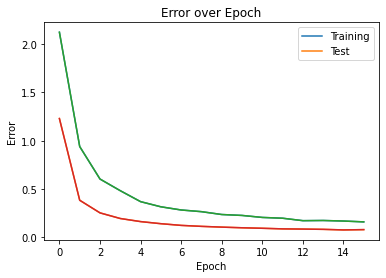

In [24]:
import matplotlib.pyplot as plt

logger.info(train_accuracy)
logger.info(val_accuracy)

_, ax = plt.subplots()

ax.plot(train_error, label="Training")
ax.plot(val_error, label="Test")
ax.set_title("Error over Epoch")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")

plt.plot(train_error)
plt.plot(val_error)

## Question 4

Suppose that you have a fully trained network, and that you wanted to find images that "fooled" it, i.e., images that are misclassified by your network.

One simple approach would be to take an input image, and then alter it in the direction of ascent of the gradient of the loss w.r.t to the pixels of that input image. Mathematically:

$
\begin{equation}
x^´ = x + \epsilon \,\text{sign}\left[\nabla_x \mathcal{L(\theta,x,y}) \right]
\end{equation}
$,

where $x^´$ is the (perturbed) image you hope will fool the classifier, $x$ is the input image, $y$ is the label of the original image, $\theta$ are the network parameters, $\epsilon$ is a hyperparameter controlling the strength of the perturbation, and $\mathcal{L}$ is the loss.

Implement this in Pytorch, using the model you trained in question 3. Generate one $x'$ for all the images in the MNIST testing set, keep the $x^´$ that sucessfully fool your model, alongside their original labels and their predicted (wrong) labels, and print out the accuracy of your model in the perturbed testing set (all the $x^´$ obtained from the images in the original testing set using the equation above), for the following epsilons: $\epsilon = 0,0.05,0.15,0.25$

**Hint**: A line of code similar to "data.requires_grad = True" is needed somewhere in your solution

### Part 1

In [25]:
from functools import partial
for epsilon in [0, 0.05, 0.15, 0.25]:
  val_accuracy, val_loss, fgsm_accuracy, fgsm_loss, fgsm_images, fgsm_preds, val_ys = evaluate(conv_net, val_dl, cross_entropy, partial(fgsm_attack, epsilon=epsilon))
  logger.info(f"EPSILON: {epsilon}")
  logger.info(f"VAL MEAN ACCURACY: {val_accuracy}")
  logger.info(f"VAL MEAN LOSS: {val_loss}")
  logger.info(f"FGSM MEAN ACCURACY: {fgsm_accuracy}")
  logger.info(f"FGSM MEAN ACCURACY: {fgsm_loss}")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
2022-03-21 02:00:37.172 | INFO     | __main__:<module>:4 - EPSILON: 0
2022-03-21 02:00:37.173 | INFO     | __main__:<module>:5 - VAL MEAN ACCURACY: 0.9764
2022-03-21 02:00:37.174 | INFO     | __main__:<module>:6 - VAL MEAN LOSS: 0.08083900050146986
2022-03-21 02:00:37.176 | INFO     | __main__:<module>:7 - FGSM MEAN ACCURACY: 0.9764
2022-03-21 02:00:37.177 | INFO     | __main__:<module>:8 - FGSM MEAN ACCURACY: 0.08083900050146986
2022-03-21 02:00:43.669 | INFO     | __main__:<module>:4 - EPSILON: 0.05
2022-03-21 02:00:43.723 | INFO     | __main__:<module>:5 - VAL MEAN ACCURACY: 0.9764
2022-03-21 02:00:43.725 | INFO     | __main__:<module>:6 - VAL MEAN LOSS: 0.08083900050146986
2022-03-21 02:00:43.727 | INFO     | __main__:<module>:7 - FGSM MEAN ACCURACY: 0.93294
2022

### Part 2

Show some of the images that fooled your network in part 1 (plt.imshow will come in handy), making sure to include both what their original and perturbed labels were in the title of your plot. Does it make sense to you that these images are fooling your network? Why or why not?

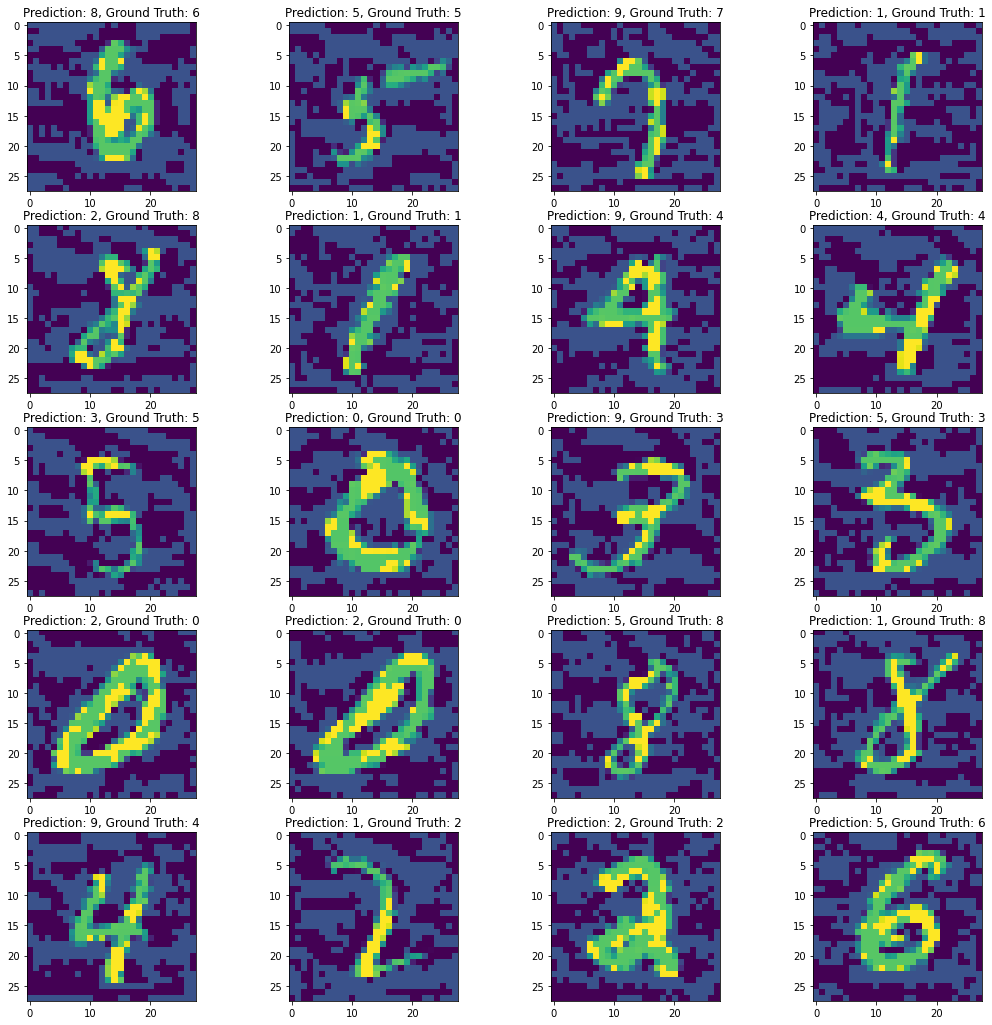

In [26]:
ROWS = 5
COLUMNS = 4
fig, ax = plt.subplots(nrows=ROWS, ncols=COLUMNS, figsize=(18, 18))
for index in range(ROWS * COLUMNS):
  sample_image = fgsm_images[index].cpu().detach().numpy()[0]
  pred_label = fgsm_preds[index]
  true_label = val_ys[index]
  current_ax = ax.ravel()[index]
  current_ax.imshow(sample_image)
  current_ax.set_title(f"Prediction: {pred_label}, Ground Truth: {true_label}")

#### Reasoning

For the most part, the misclasifications are reasonable to a certain extent. Most of the errenous classification made are a direct result of being unable to classify certain delimiting sections.

For example, the 6 on the bottom right is predicted to be 5, which isn't far from the truth. In fact, 5 and 6 have pretty similar shapes with the exception of the section which closes the number. If the 6 were to have a break in its loop, someone could reasonably assert that it could be a 5.

Similarly, a similar pattern can be seen with the 9 (predicted to be a 4) on the bottom left and the 7 predicted to be a 9 (first row, third column).

## Question 5 (6505 only)

Can you think of a way to make your network more robust to these perturbed images? Does your proposal have drawbacks? Run any experiments you feel are needed to prove your claims.

**Note**: You are not expected to find a perfect solution, just something that makes sense and has some evidence backing it up. You will be marked on the persuasiveness of your argument/experiments and how much sense your proposal makes, not the overall improvements in robustness you achieve (however, if your proposal worsens the problem, then that's a pretty solid hint you're going in the wrong direction).